# K-nn

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA


In [3]:
%run ./data-importation-and-formatting.py

In [4]:
data_folder = "../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"

lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Bacterial Pneumonia", "Covid", "Normal"],
                                 "img_dir" : lst_dirs_condition})


## K-nn sur les distributions de niveaux de gris

In [18]:
# Calcul de la distribution des niveaux de gris
color_distrib_df = compute_color_distribution_from_dir_imgs(conditions[0])
color_distrib_df['label'] = conditions[0]

for c in range(2,len(conditions)):
    distrib_c = compute_color_distribution_from_dir_imgs(conditions[c])
    distrib_c['label'] = conditions[c]
    color_distrib_df = pd.concat([color_distrib_df,distrib_c])
color_distrib_df = color_distrib_df.reset_index().drop(columns='index')


In [87]:
# Retirer les valeurs de pixel qui n'apparaissent jamais
color_distrib_df.sum(numeric_only=True, axis=0).describe()


count    255.000000
mean      83.000000
std       69.015224
min        0.012496
25%       15.059776
50%       71.135538
75%      155.400690
max      217.781486
dtype: float64

In [56]:
# Définition de la variable cible et des features
X = color_distrib_df.drop(columns='label')
y = 0 + 1*(color_distrib_df.label=="COVID")
# y = color_distrib_df.label

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

knn = neighbors.KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [59]:
y_pred = knn.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred))

pd.crosstab(y_pred, y_test, rownames=['pred'], colnames=['true'])


              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3494
           1       0.53      0.40      0.45       739

    accuracy                           0.83      4233
   macro avg       0.71      0.66      0.68      4233
weighted avg       0.82      0.83      0.82      4233



true,0,1
pred,,
0,3237,447
1,257,292


In [74]:
# Avec la métrique KL : TODO
def KL_div(x,y):
    return np.sum(x*np.log(x/y))
def KL_dist(x,y):
    return KL_div(x,y) + KL_div(y,x)
knn_kl = neighbors.KNeighborsClassifier(n_neighbors=10, metric=KL_dist)
knn_kl.fit(X_train, y_train)

KNeighborsClassifier(metric=<function KL_dist at 0x000002C8A1A23CA0>,
                     n_neighbors=10)

In [ ]:
y_pred_kl = knn_kl.predict(X_test)
print(classification_report(y_test, y_pred_kl))

pd.crosstab(y_pred_kl, y_test, rownames=['pred'], colnames=['true'])

In [ ]:
# Optimisation des paramètres 
skf = StratifiedKFold(n_splits=10, shuffle = True)
folds = list(skf.split(X_train, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {
    'n_neighbors' : [5,10,50,100,150],
    'metric' : ['euclidean', 'ChebyshevDistance', 'mahalanobis', 'minkowski'],
    'p' : [0,2,5]
}
grid_knn = GridSearchCV(knn, param_grid = grid_param, cv=folds)
grid_knn.fit(X_train, y_train)

In [69]:
print(grid_knn.score(X_test, y_test))

y_pred_best = grid_knn.predict(X_test)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

0.8509331443420742
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      3494
           1       0.66      0.30      0.41       739

    accuracy                           0.85      4233
   macro avg       0.76      0.63      0.66      4233
weighted avg       0.83      0.85      0.83      4233



true,0,1
pred,,
0,3382,519
1,112,220


## K-nn sur les résultats d'une PCA

### Sur les images sans masque

In [15]:
# # Importation des images
# img_df = load_img_dir_in_df(conditions[0])
# img_df['label'] = conditions[0]

# for c in range(1,len(conditions)):
#     img_df_c = load_img_dir_in_df(conditions[c])
#     img_df_c['label'] = conditions[c]
#     img_df = pd.concat([img_df,img_df_c])
# img_df = img_df.reset_index().drop(columns='index')


In [5]:
# Importation des images
img_df = load_img_dir_in_df('Viral Pneumonia')
img_df['label'] = 0
img_df_c = load_img_dir_in_df('COVID')
img_df_c['label'] = 1
img_df = pd.concat([img_df,img_df_c]).reset_index().drop(columns='index')

del img_df_c

In [ ]:
plt.imshow(np.array(img_df.drop(columns='label').iloc[0,:]).reshape(299,299), cmap='gray')

In [18]:
print(img_df.shape)
print(img_df.dtypes.unique())
img_df.head()

(21165, 89402)
[dtype('uint8') dtype('O')]


,0,1,2,3,4,5,6,7,8,9,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,label
0,1,1,2,3,3,3,3,4,11,17,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
1,0,3,9,16,21,24,25,25,25,25,...,36,24,3,4,7,9,10,11,11,Viral Pneumonia
2,0,2,2,5,9,10,29,214,156,49,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
4,138,140,141,143,145,147,148,148,148,149,...,28,28,28,28,28,29,29,29,29,Viral Pneumonia


In [12]:
X = img_df.drop(columns='label')
# y = 0 + 1*(img_df.label=="COVID")
y = img_df.label
# Séparation en échantillons d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
# X_train_pca, X_val_pca, y_train_pca, y_test_pca = train_test_split(X_train, y_train, test_size=0.35, random_state=123)

In [18]:
print(X_train_pca.shape)
y_train_pca.mean()

(2579, 89401)


np.float64(0.7243117487398216)

In [20]:
pca90 = PCA(n_components=0.9, random_state=42)

X_train_pca = pca90.fit_transform(X_train)

print(X_train_pca.shape) 

X_test_pca = pca90.transform(X_test)

print(X_test_pca.shape)

(3968, 50)
(993, 50)


In [19]:
# pca90 = PCA(n_components=0.9, random_state=42)

# X_train_pca_res = pca90.fit_transform(X_train_pca)

# print(X_train_pca_res.shape)

# X_val_pca_res = pca90.transform(X_val_pca)
# print(X_val_pca_res.shape) 

(2579, 49)
(1389, 49)


In [28]:
# Instanciation

knn_pca = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {
    'n_neighbors' : [5, 10, 50, 100],
    'metric' : ['chebyshev',  'minkowski'],
    'p' : [1,2,5]
}
grid_knn = GridSearchCV(knn_pca, param_grid = grid_param, cv=folds)
grid_knn.fit(X_train_pca, y_train)

c:\Users\peure\anaconda3\envs\proj_analyse_pulmonaire\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\peure\anaconda3\envs\proj_analyse_pulmonaire\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\peure\anaconda3\envs\proj_analyse_pulmonaire\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\peure\anaconda3\envs\proj_analyse_pulmonaire\lib\site-packages\sklearn\base.py", 

GridSearchCV(cv=[(array([   1,    2,    4, ..., 3965, 3966, 3967]),
                  array([   0,    3,   21,   22,   26,   27,   28,   42,   44,   53,   57,
         69,   77,   80,   84,   91,   98,  104,  109,  114,  118,  120,
        122,  131,  151,  152,  153,  155,  157,  170,  177,  185,  196,
        198,  203,  207,  219,  222,  226,  229,  230,  232,  237,  239,
        240,  241,  242,  243,  246,  248,  252,  259,  263,  272,  274,
        275,  276,  277,  279,  290,  291,  293,  295,  315,  319,  321,
        326,  327,  330,  333,  336,  341,  342,  346,  349,  362,  363,
        36...
       3765, 3772, 3775, 3777, 3778, 3788, 3795, 3797, 3801, 3802, 3806,
       3810, 3816, 3824, 3825, 3831, 3835, 3840, 3849, 3852, 3855, 3859,
       3860, 3862, 3867, 3870, 3872, 3875, 3876, 3881, 3886, 3892, 3894,
       3899, 3900, 3905, 3908, 3924, 3928, 3930, 3931, 3941, 3944, 3945,
       3948]))],
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['ChebyshevDistance', 'minkowski'],
                         'n_neighbors': [5, 10, 50, 100], 'p': [1, 2, 5]})

In [29]:
print(grid_knn.score(X_test_pca, y_test))

y_pred_best = grid_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])

0.9798590130916415
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       259
           1       0.99      0.98      0.99       734

    accuracy                           0.98       993
   macro avg       0.97      0.98      0.97       993
weighted avg       0.98      0.98      0.98       993



true,0,1
pred,,
0,253,14
1,6,720


### Sur les images masquées

In [10]:
# Importation des images
img_df = load_masked_img_dir_in_df('Viral Pneumonia', )
img_df['label'] = 0
img_df_c = load_masked_img_dir_in_df('COVID')
img_df_c['label'] = 1
img_df = pd.concat([img_df,img_df_c]).reset_index().drop(columns='index')

del img_df_c

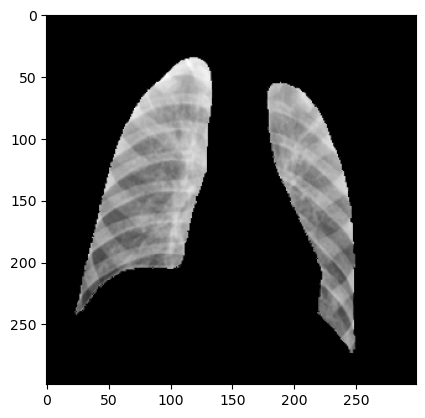

In [11]:
plt.imshow(np.array(img_df.drop(columns='label').iloc[0,:]).reshape(299,299), cmap='gray')

In [12]:
X = img_df.drop(columns='label')
# y = 0 + 1*(img_df.label=="COVID")
y = img_df.label
# Séparation en échantillons d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
pca90_masks = PCA(n_components=0.9, random_state=42)

X_train_pca = pca90_masks.fit_transform(X_train)

print(X_train_pca.shape) 

X_test_pca = pca90_masks.transform(X_test)

print(X_test_pca.shape)

(3968, 324)
(993, 324)


In [16]:
knn_pca_masks = neighbors.KNeighborsClassifier(metric='chebyshev')
knn_pca_masks.fit(X_train_pca, y_train)

KNeighborsClassifier(metric='chebyshev')

In [19]:
# Instanciation

knn_pca_masks = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

grid_param = {
    'n_neighbors' : [2, 5, 10, 50, 100],
    'metric' : ['chebyshev',  'minkowski', 'correlation'],
    'p' : [1,2,5]
}
grid_knn_masks = GridSearchCV(knn_pca_masks, param_grid = grid_param, cv=folds)
grid_knn_masks.fit(X_train_pca, y_train)

print(grid_knn_masks.best_params_)

In [ ]:
print(grid_knn_masks.score(X_test_pca, y_test))

y_pred_best = grid_knn_masks.predict(X_test_pca)
print(classification_report(y_test, y_pred_best))
pd.crosstab(y_pred_best, y_test, rownames=['pred'], colnames=['true'])